# Magnetic Spectrum

This notebook demonstrates the algorithm behind obtaining magnetic spectra.

## Imports
First we import the necessary libraries.

In [2]:
import time
from multiprocessing import set_start_method

from dotenv import dotenv_values
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.collections import LineCollection
from matplotlib.colors import LogNorm, Normalize
from numpy import typing as npt
from phdhelper import mpl
from phdhelper.colours import sim as colours
from scipy import optimize
from tqdm import tqdm

import hybrid_jp as hj
import hybrid_jp.analysis as hja


## Setting up the data

Some parameters are set using environment variables. We load the deck first then the
`.sdf` files. This is so we can set the timestep, `dt`, which is defined in the deck
output. We also scale the magnetic field from its SI base units, Teslas $T$, to
nanoTestlas $nT$, and the same for the grid midpoints, $m\rightarrow km$. Finally we
create a `CentredShock` object that holds the simulation data and has methods for
splitting the data held indside `sdf` files and grouping them into 'chunks', based on
distance upstream and downstream of the shock.


In [3]:
env = dotenv_values("../../../.env")
START, END = 20, 200
set_start_method("fork")
mpl.format()
data_folder = str(env["DATA_DIR"])
deck = hja.load_deck(data_dir=data_folder)
SDFs, fpaths = hja.load_sdfs_para(
    sdf_dir=data_folder,
    dt=deck.output.dt_snapshot,
    threads=7,
    start=START,
    stop=END,
)
for SDF in SDFs:
    SDF.mag *= 1e9  # Convert to nT
    SDF.mid_grid *= 1e-3  # Convert to km
cs = hja.CenteredShock(SDFs, deck)

100%|██████████| 181/181 [00:06<00:00, 29.36it/s]


## Getting values in a 'frame'

A 'frame' is an array of values at a given time and in a given chunk. The method
`cs.get_qty_in_frame(func, chunk, t_idx)` will slice the data returned by the function
`func`, at timestep `t_idx`, at chunk `chunk`. `func` must have the signature
`Callable[[SDF], NDArray[np.float64]]`, i.e. it must take exactly one parameter, an
`SDF` object, and return an array. Below wer define the function `get_bx()` which
returns the $b_x$ component from the `SDF`. This returns the whole array, which
`get_qty_in_frame()` then slices to the correct range in $x$ to line up with the
specified `chunk`.

:::{important}
the property `cs.n_chunks` must be set before calling most methods on `cs`, otherwise an
`NChunksNotSetError` will be raised.
:::

:::{note}
Alternatively, we could have obtained the meadian value of $b_x$ in each cell, i.e. $\left<b_x\right>_y$, using a function such as:

```python
def get_median_bx(sdf: SDF) -> NDArray[np.float64]:
    return np.median(sdf.mag.bx, axis=1)
```
:::


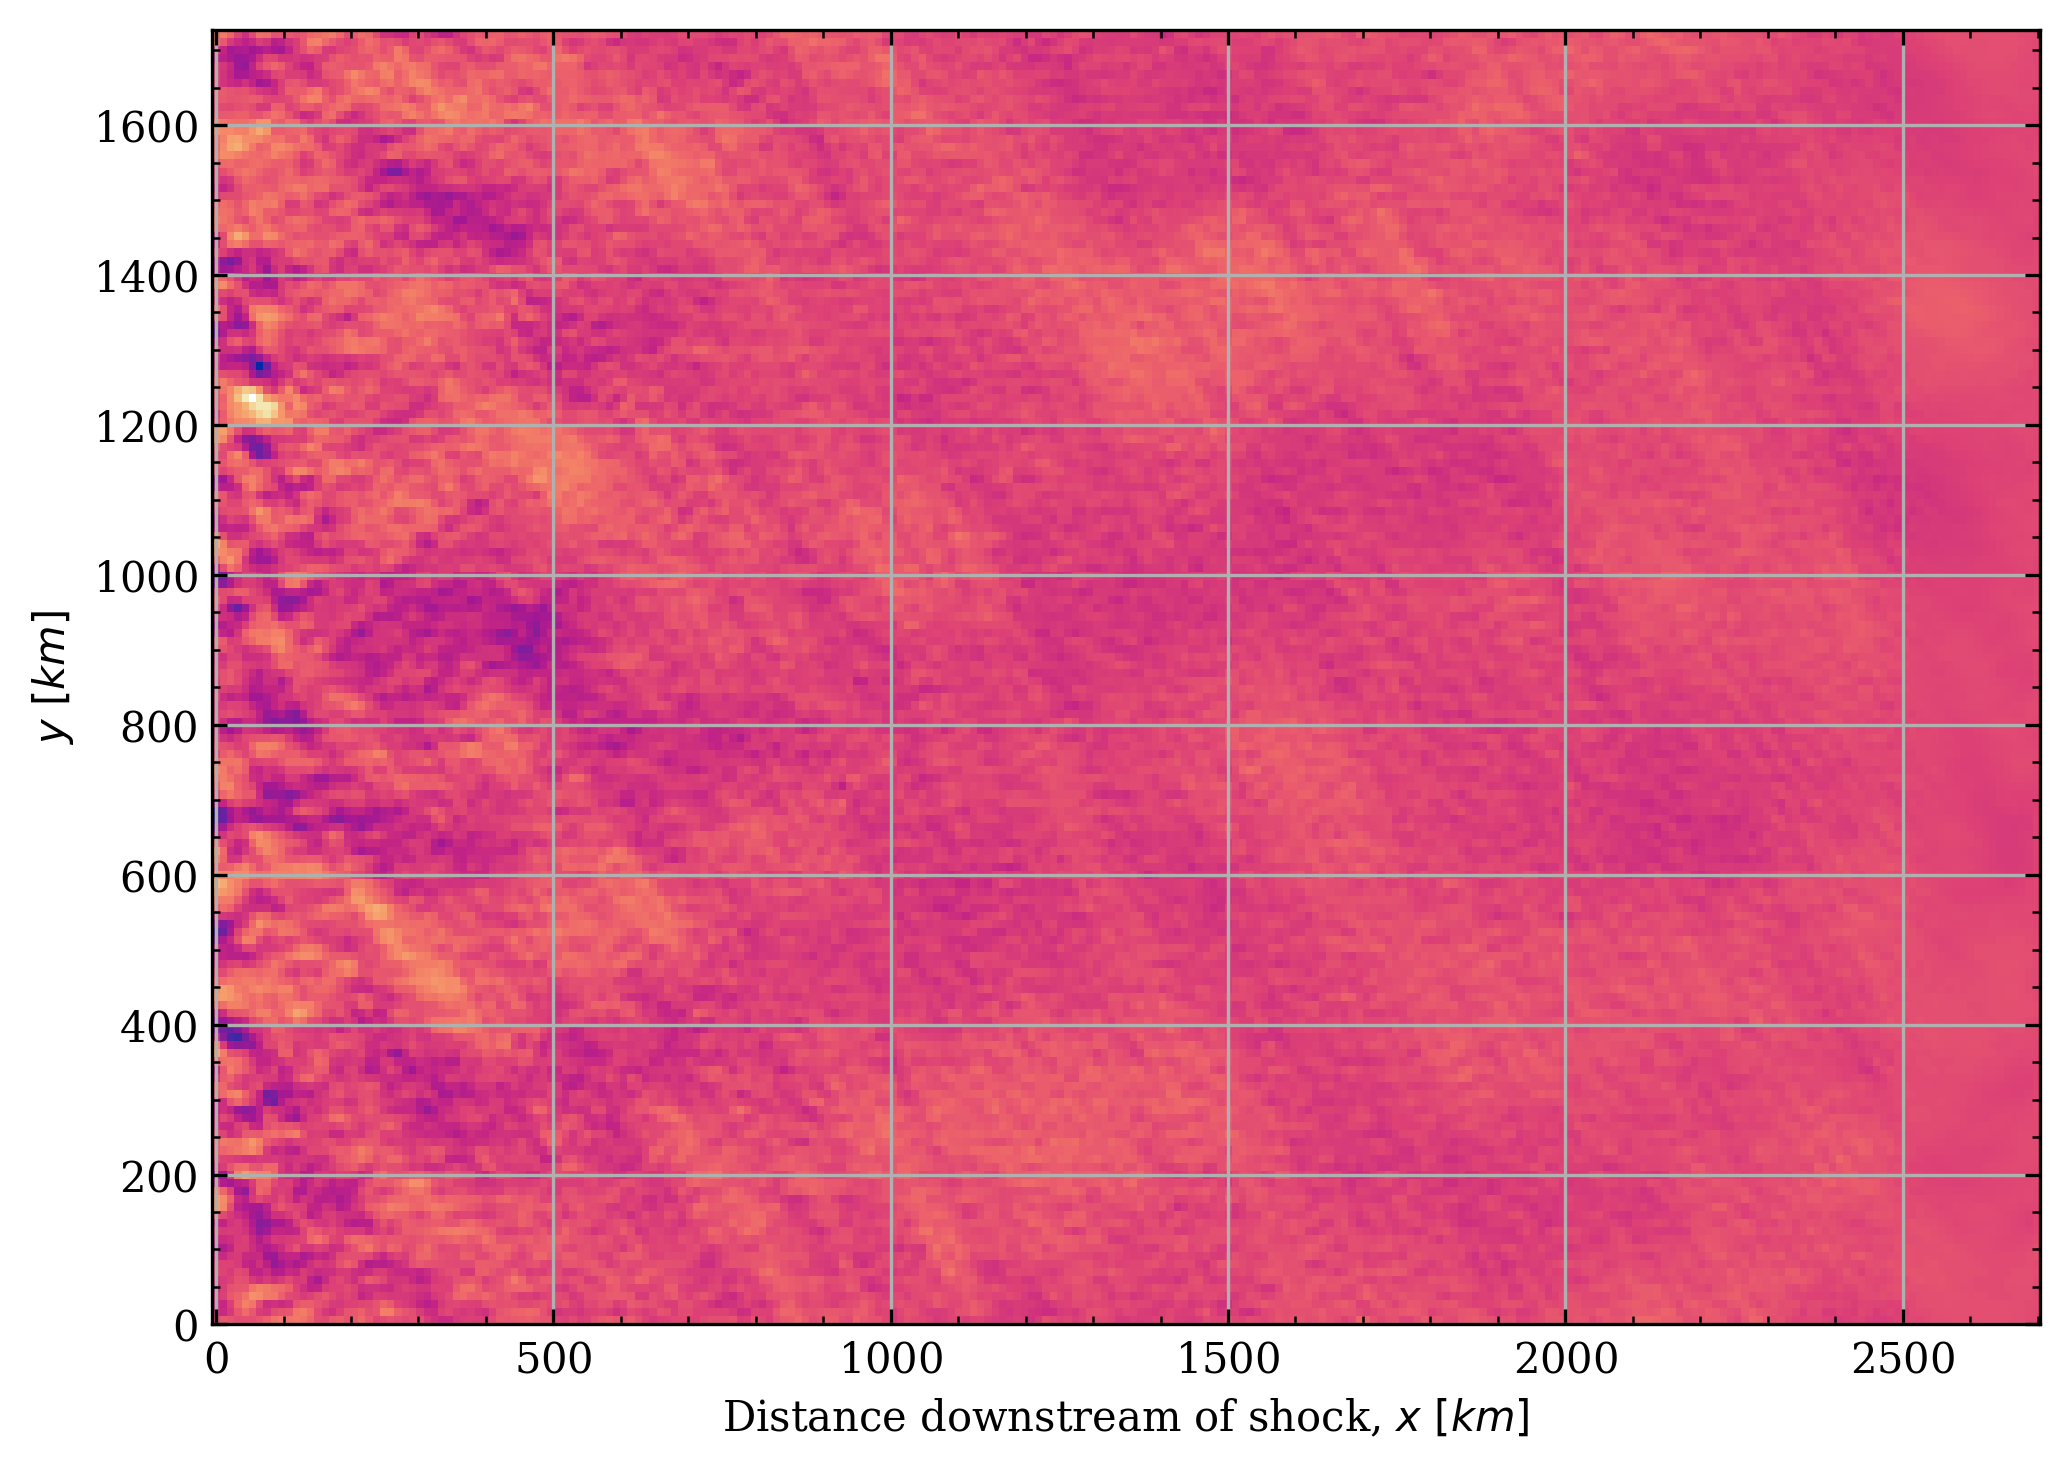

In [4]:
N_CHUNKS = 10
cs.n_chunks = N_CHUNKS
shock_chunk = cs.downstream_start_chunk


def get_bx(sdf: hj.sdf_files.SDF) -> npt.NDArray[np.float64]:
    return sdf.mag.bx


t = int(np.argmax(cs.valid_chunks[shock_chunk, :]))
qty, slc = cs.get_qty_in_frame(get_bx, shock_chunk, t)
plt.pcolormesh(
    cs.grid.x[slice(*slc)] - cs.grid.x[cs.get_x_offset_for_frame(shock_chunk, t)],
    cs.grid.y,
    qty.T,
)
plt.ylabel(r"$y\ [km]$")
plt.xlabel(r"Distance downstream of shock, $x\ [km]$")
plt.tight_layout()
plt.show()

## 2D FFT and Subdivisions

We now perform a 2d Fourier transform on the frame. Under the hood, this uses [`np.fft.fft2()`](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft2.html) function. Calling the function [](#ffts.power_xy)

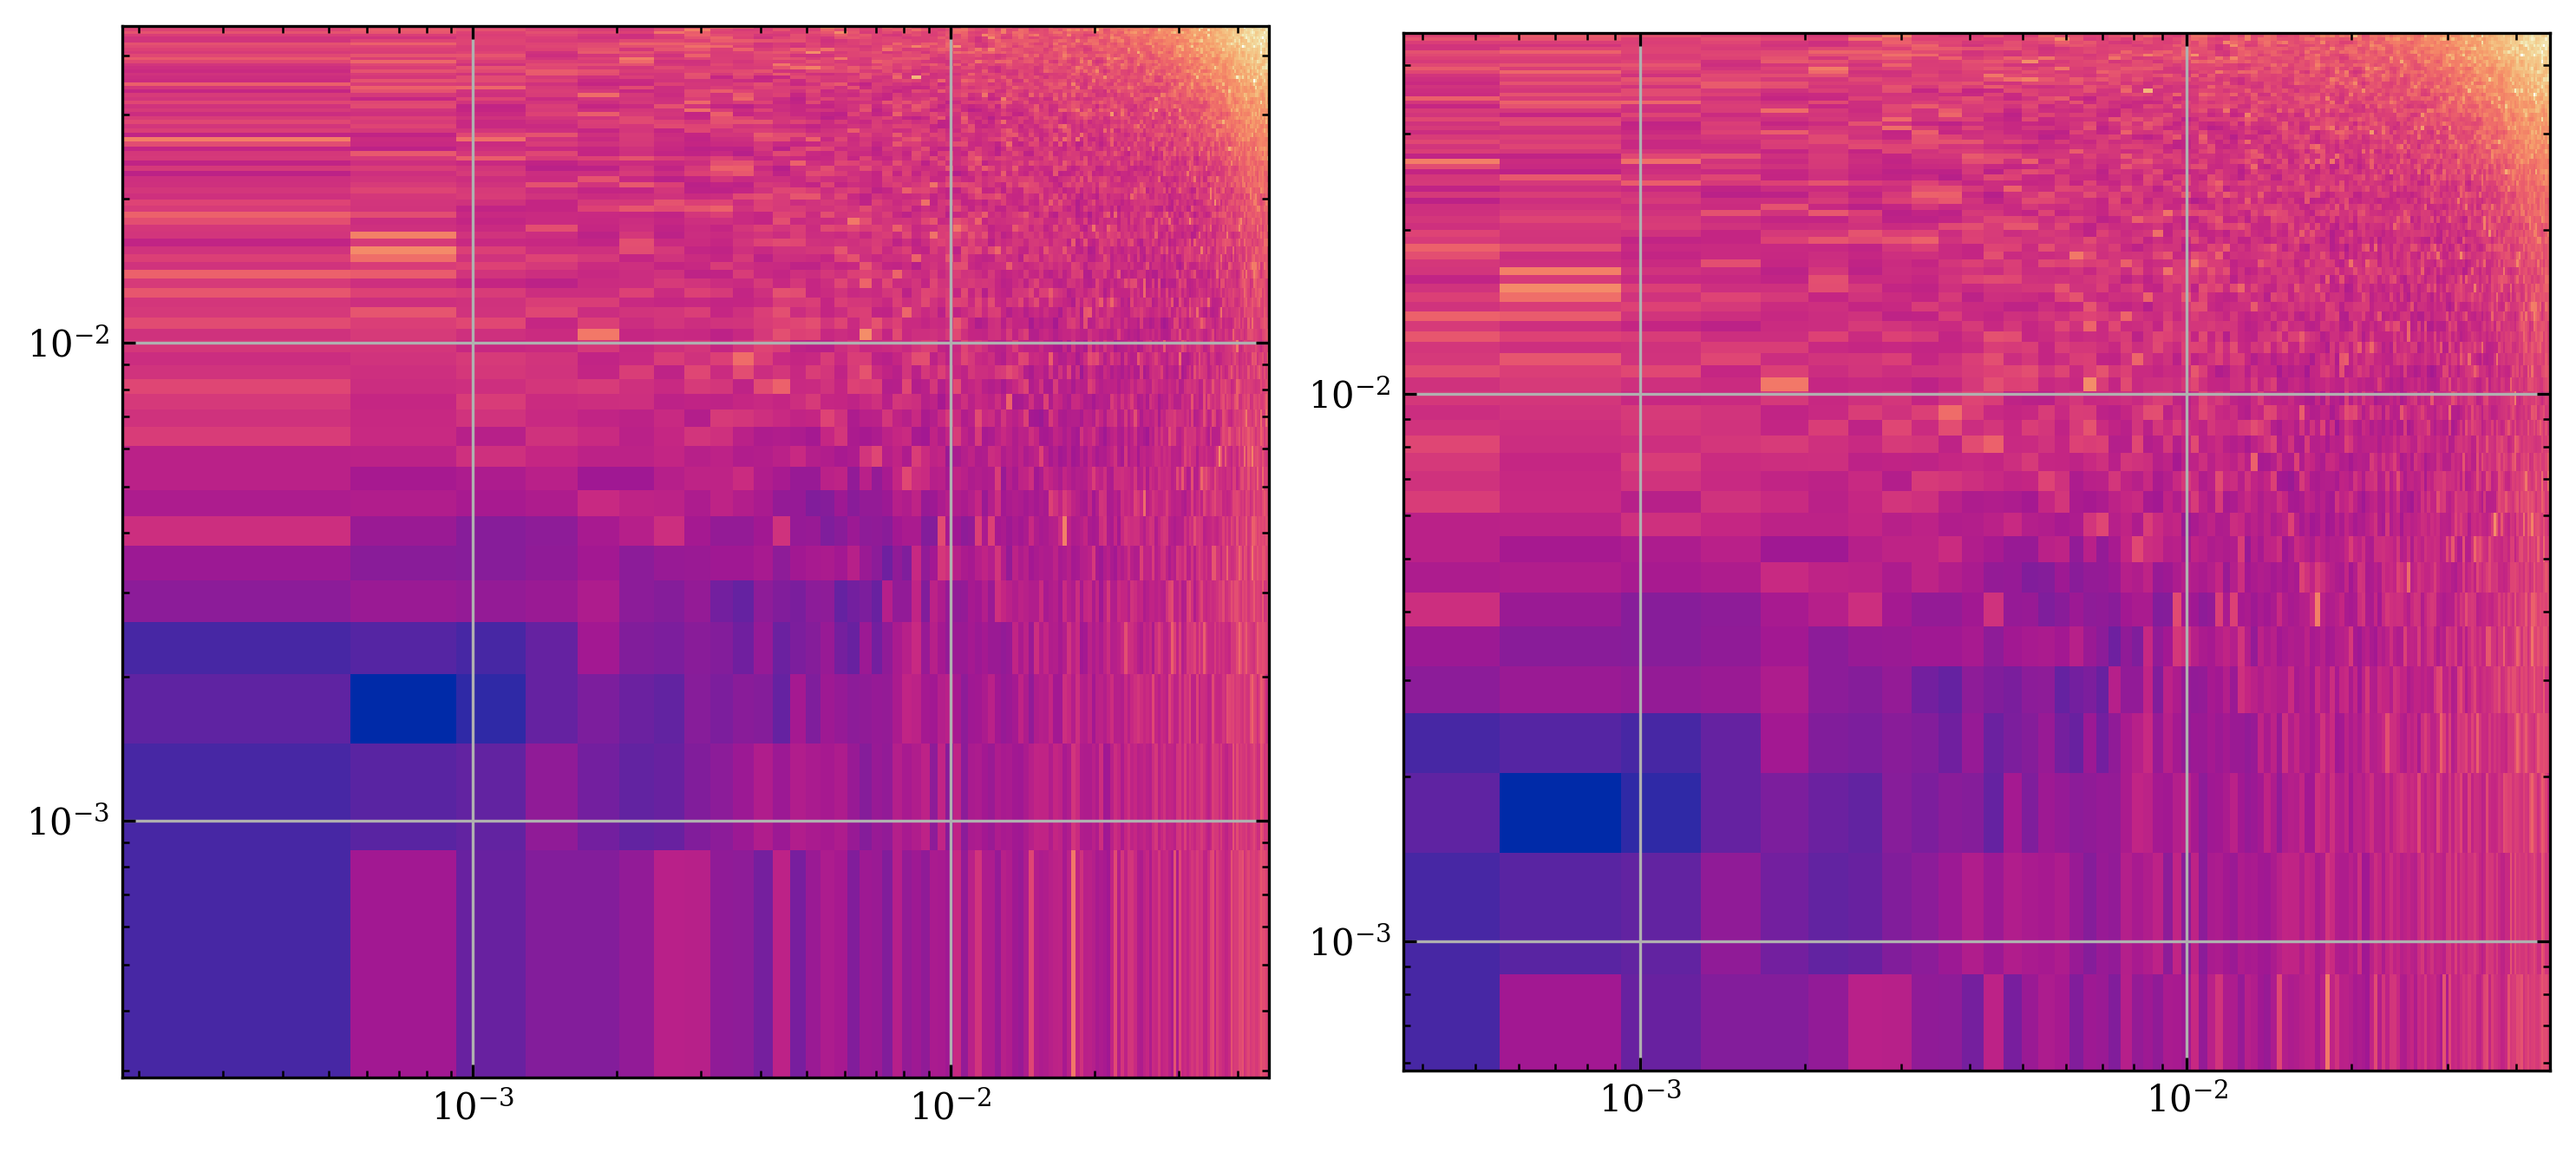

In [4]:
bz_func = lambda x: x.mag.bz
bz = cs.get_qty_in_frame(bz_func, shock_chunk, t)[0]
pxy, kx, ky = hja.ffts.power_xy(bz, cs.dx, cs.dy)
axs: list[plt.Axes]
fig, axs = plt.subplots(1, 2, figsize=(10, 5))  # type: ignore
axs[0].pcolormesh(kx, ky, pxy.T, norm=LogNorm())
axs[0].set_yscale("log")
axs[0].set_xscale("log")
axs[0].set_aspect("equal")

pxy4, kx4, ky4 = hja.ffts.subdivide_repeat(4, pxy, kx, ky)
axs[1].pcolormesh(kx4, ky4, pxy4.T, norm=LogNorm())
axs[1].set_yscale("log")
axs[1].set_xscale("log")
axs[1].set_aspect("equal")
fig.tight_layout()
plt.show()


(100,) (100,) 800


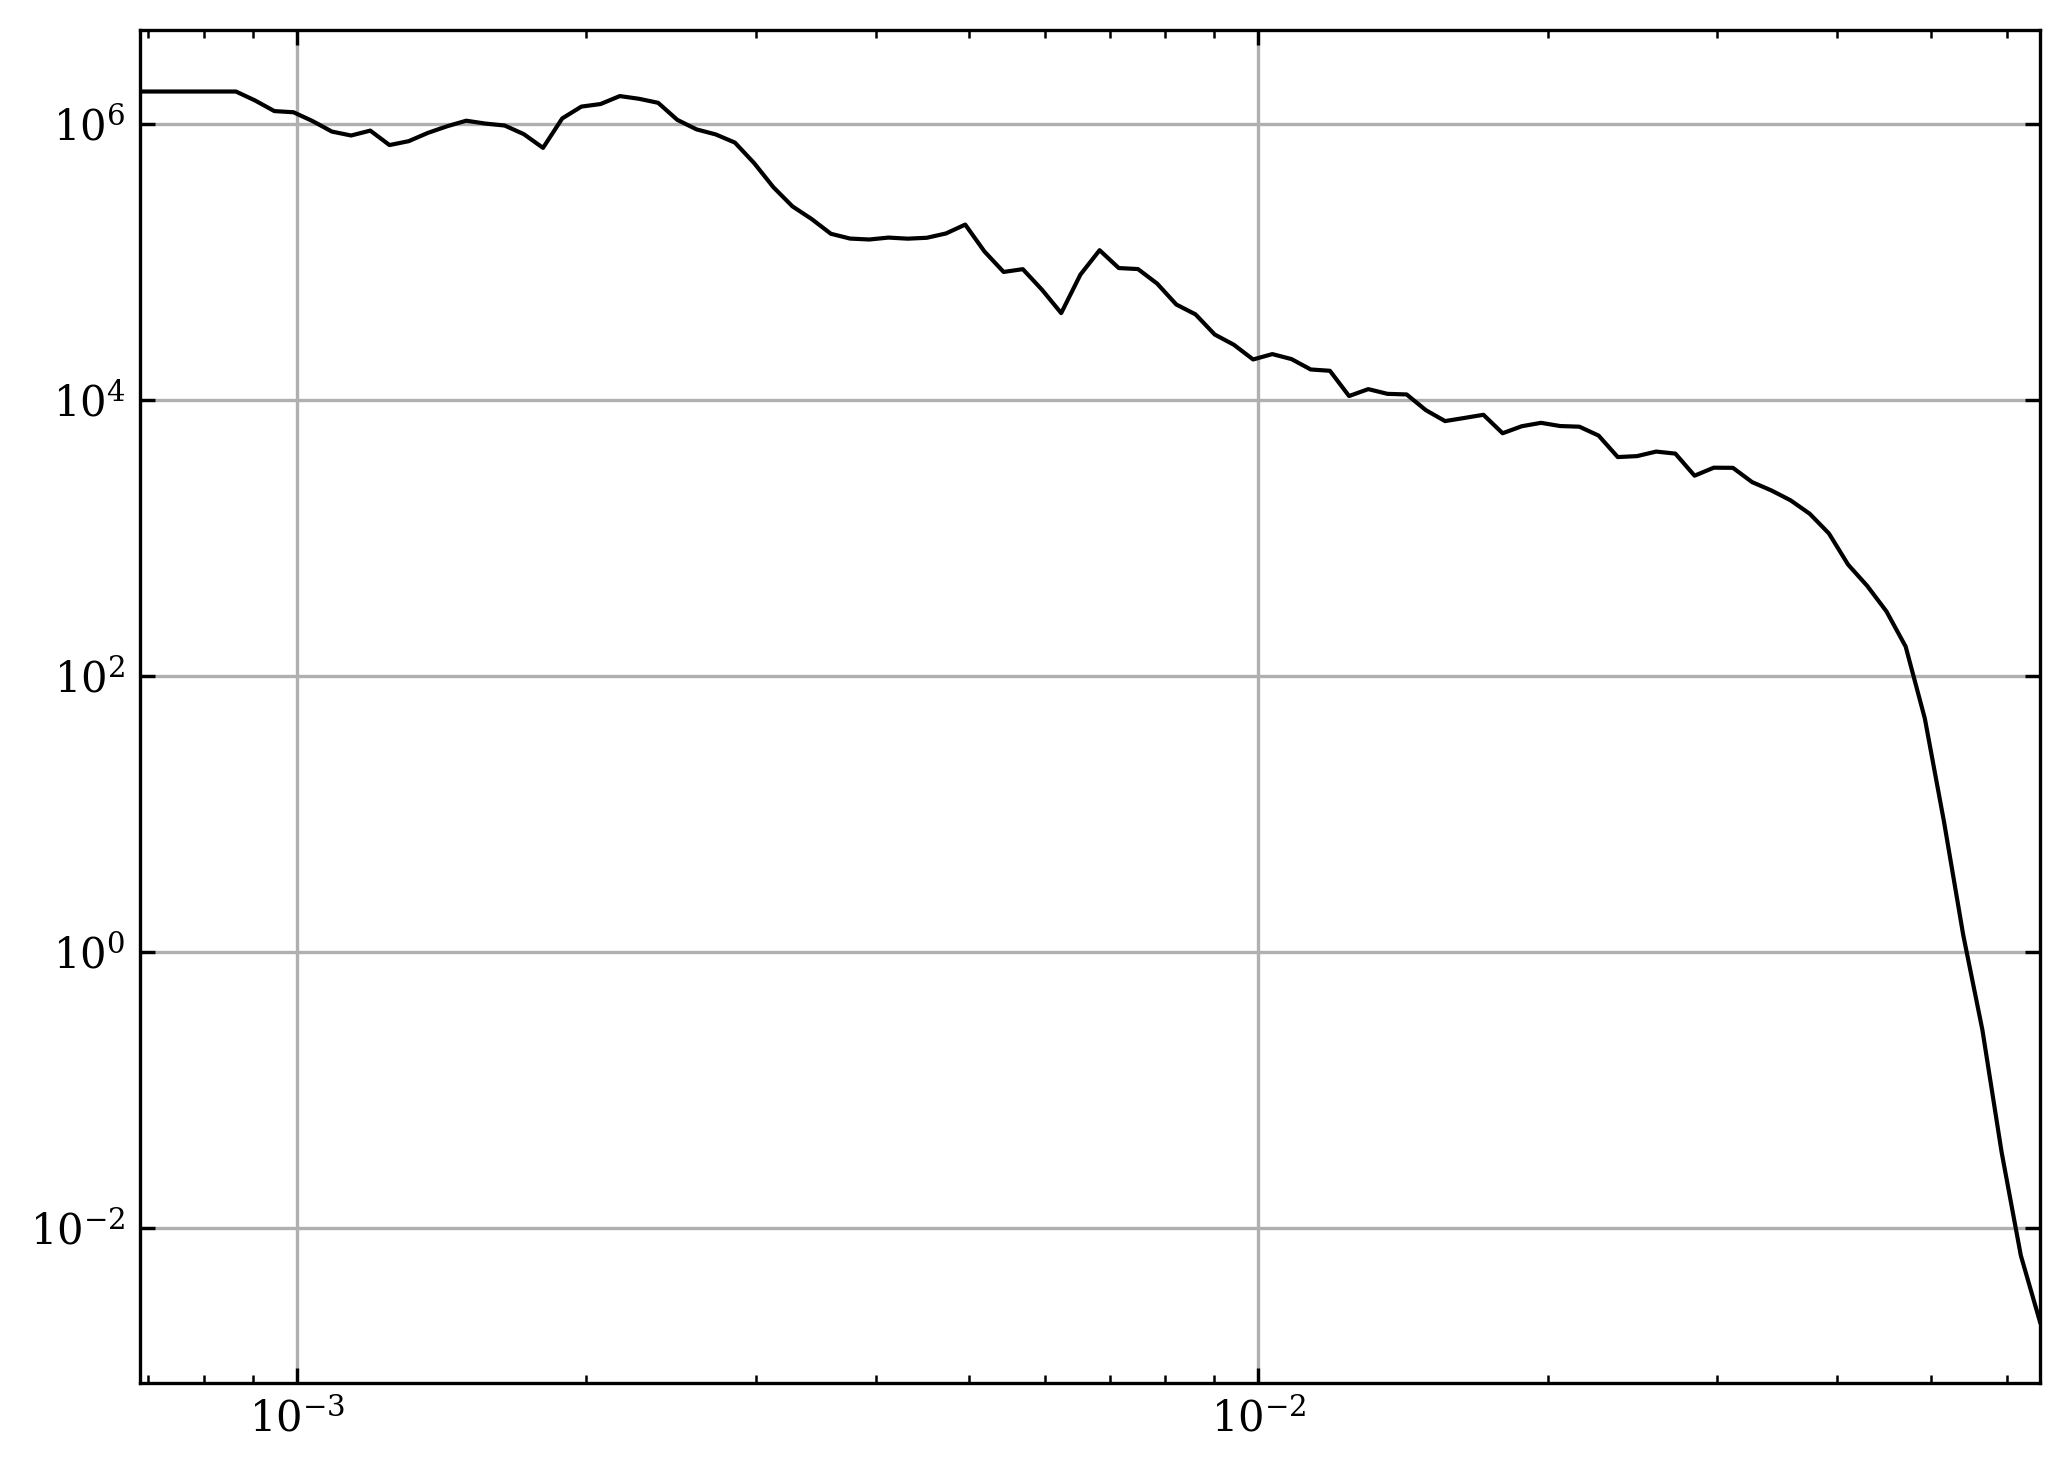

In [5]:
n_r_bins: int = 100
n_sub: int = 8
Pr4, kr = hja.ffts.radial_power(pxy, kx, ky, n_sub, n_r_bins)
kr = np.logspace(np.log10(kr[0]), np.log10(kr[-1]), n_r_bins)
print(Pr4.shape, kr.shape, n_r_bins * n_sub)

fig, ax = plt.subplots()  # type: ignore
ax.plot(kr, Pr4, c="k", ls="-")
ax.set_xscale("log")
ax.set_yscale("log")

fig.tight_layout()
plt.show()


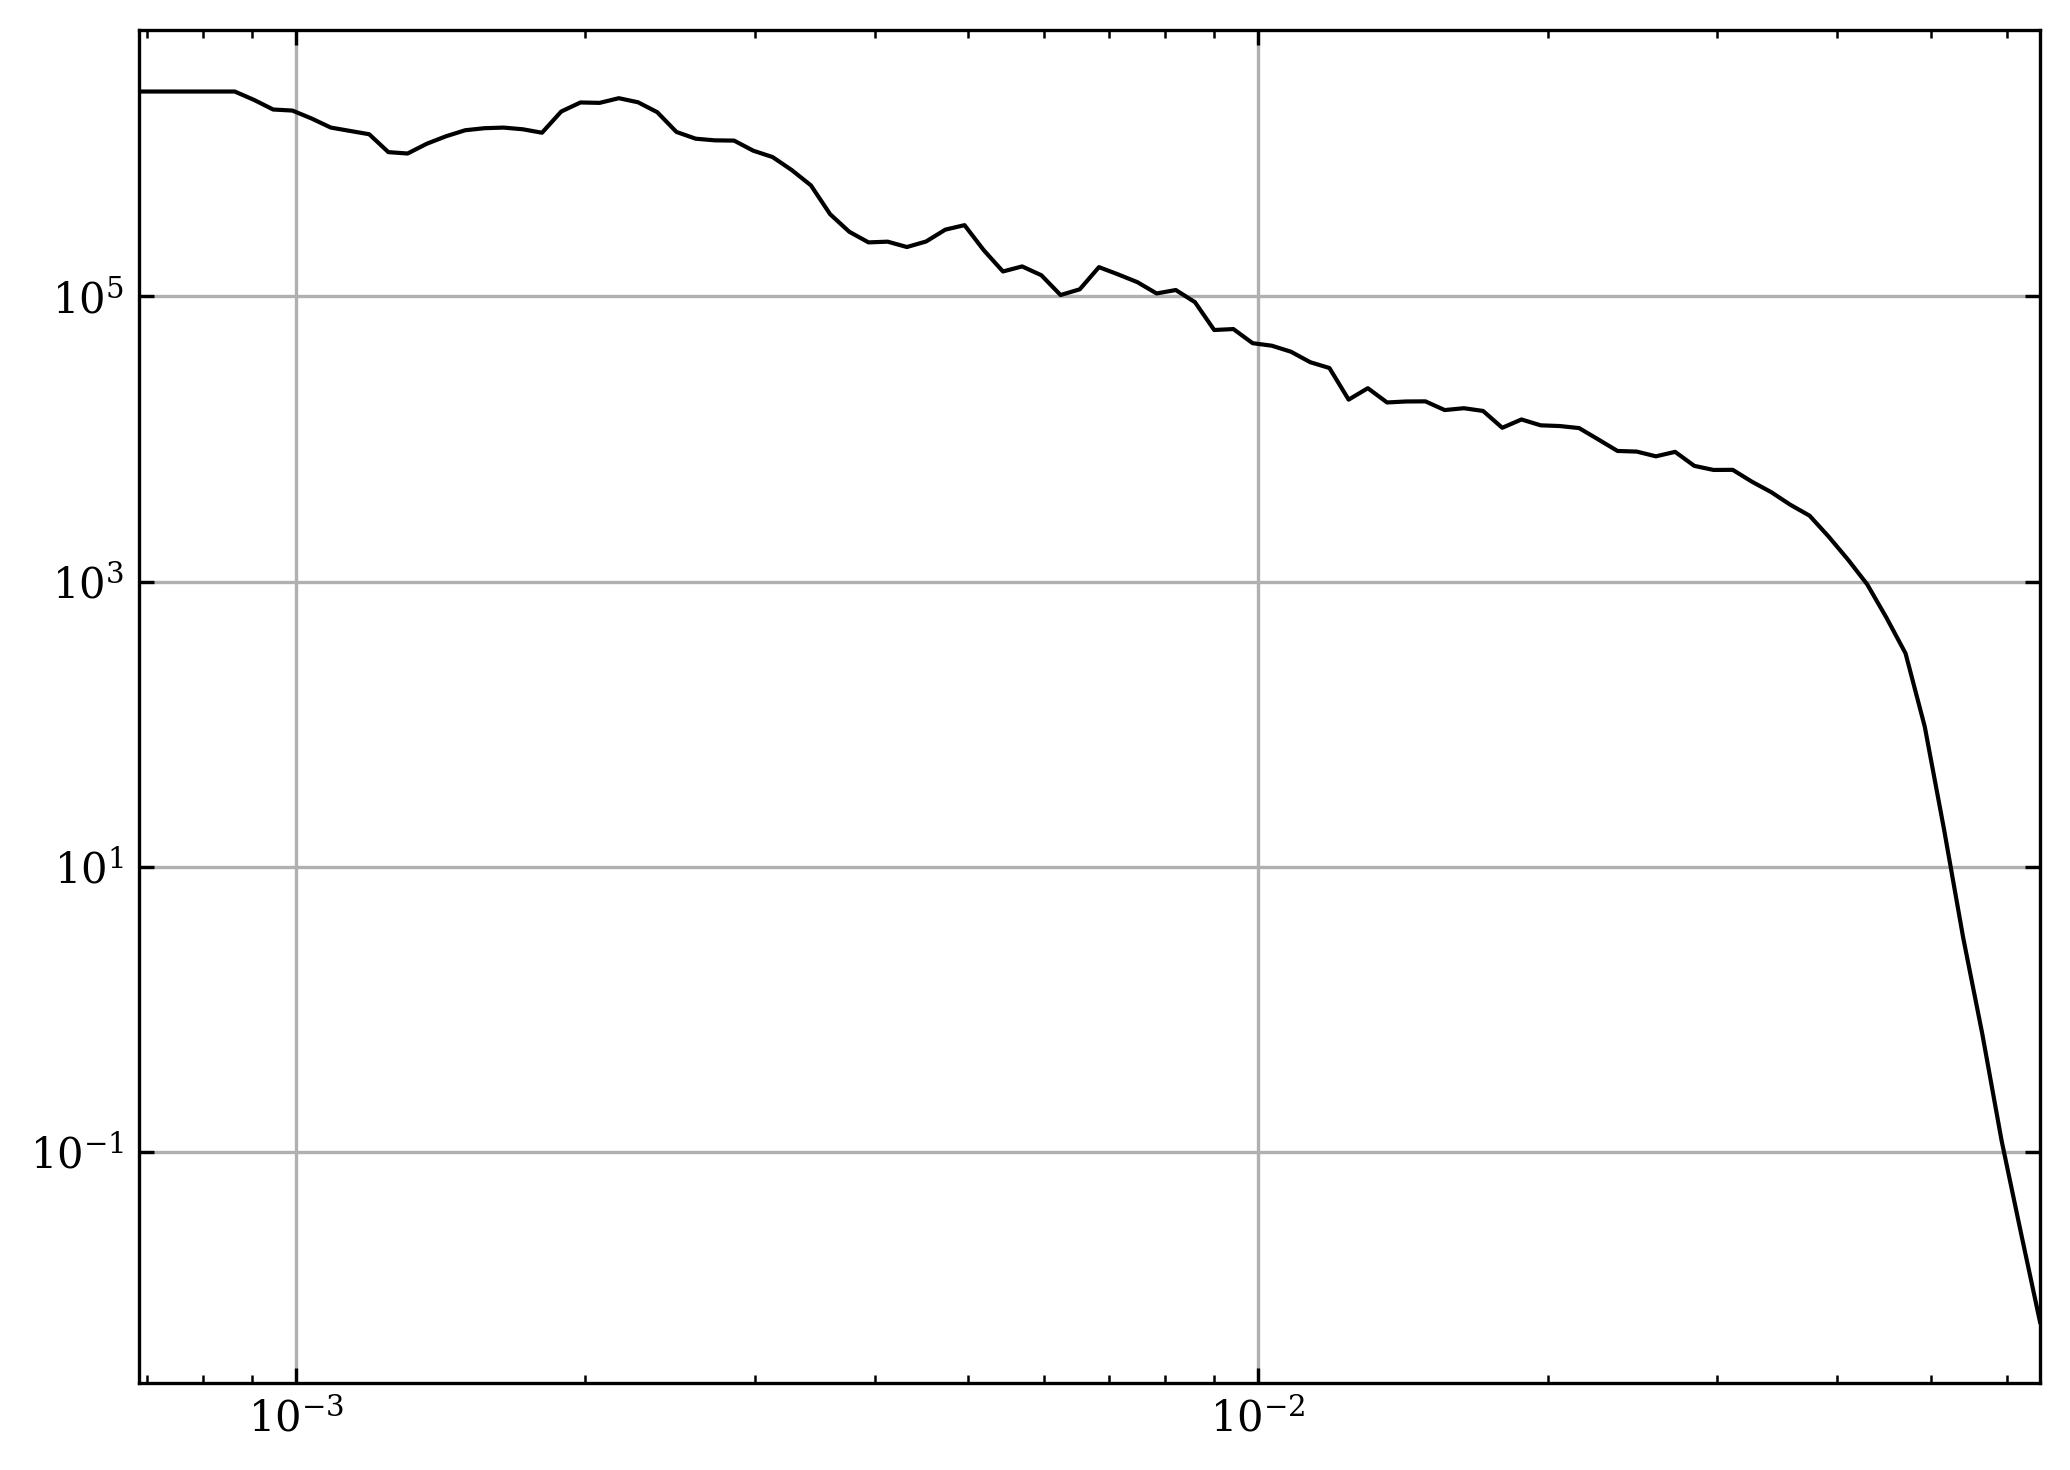

In [6]:
pr, kr = hja.frame_power(cs, shock_chunk, t, n_sub, n_r_bins)
fig, ax = plt.subplots()
ax.loglog(kr, pr, c="k", ls="-")
fig.tight_layout()
plt.show()



In [7]:
vc = cs.valid_chunks
val: list[list[int]] = [list(np.nonzero(vc[i, :])[0]) for i in range(vc.shape[0])]


def get_power_para(
    cs: hja.CenteredShock,
    val: list[list[int]],
    n_r_bins: int,
    n_sub: int,
):
    assert cs.n_chunks is not None

    kr = np.empty(n_r_bins)
    avg_pwr = np.empty((n_r_bins, cs.n_chunks))

    start_time = time.time()
    for i, v in enumerate(val):
        out = np.empty((n_r_bins, len(v)))
        for j, t in tqdm(enumerate(v), total=len(v), desc=f"Chunk {i}/{cs.n_chunks-1}"):
            out[:, j], kr = hja.frame_power(cs, i, t, n_sub, n_r_bins)
        avg_pwr[:, i] = out.mean(axis=1)

    end_time = time.time()
    print(f"Time taken: {end_time - start_time:.1f}s")

    return avg_pwr.T, kr


avg_pwr, kr = get_power_para(cs, val, n_r_bins, n_sub)


Chunk 9/9: 100%|██████████| 8/8 [00:01<00:00,  7.76it/s]

Time taken: 125.8s


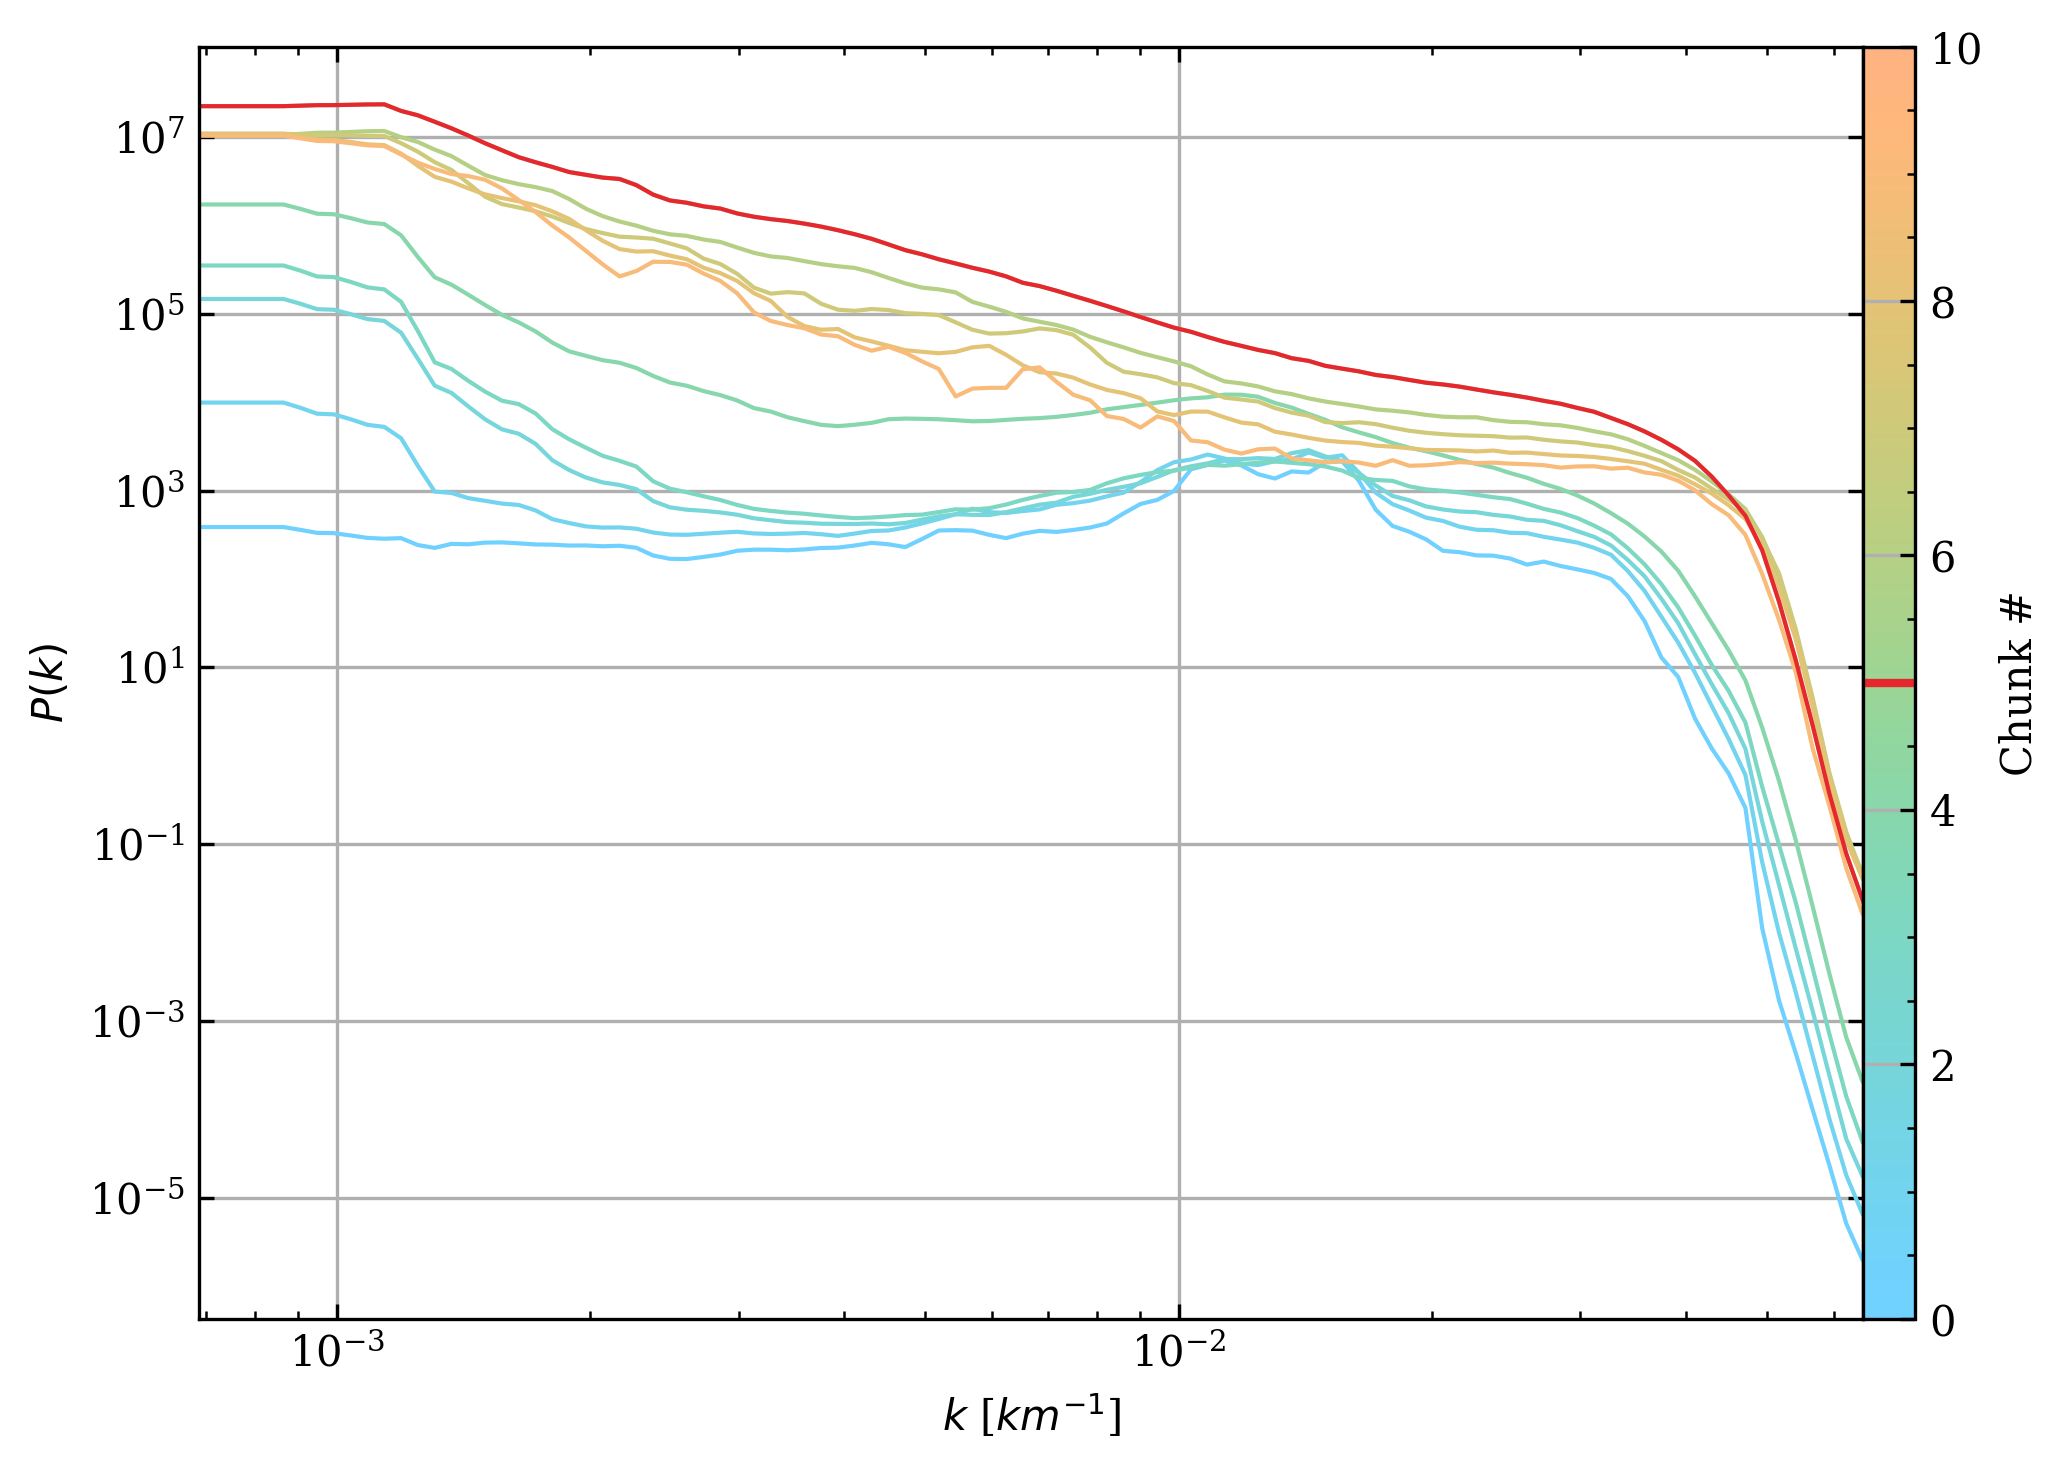

In [8]:
fig, axs = plt.subplots(1, 2, gridspec_kw=dict(width_ratios=[97, 3]))  # type: ignore
ax = axs[0]
cax = axs[1]


segments = np.array([np.stack([kr] * cs.n_chunks, axis=0), avg_pwr])
segments = np.moveaxis(segments, [0, 1, 2], [2, 0, 1])
norm = Normalize(vmin=0, vmax=cs.n_chunks)
lc = LineCollection(
    segments,  # type: ignore
    array=np.arange(cs.n_chunks),
    norm=norm,
    cmap=mpl.Cmaps.isoluminant,
)  # type: ignore
ax.add_collection(lc)  # type: ignore
ax.loglog(*segments[shock_chunk].T, c=colours.red())
ax.set_xscale("log")
ax.set_yscale("log")

fig.colorbar(lc, cax=cax, label="Chunk #")
cax.axhline(shock_chunk, c=colours.red(), lw=2)

ax.set_xlabel("$k$ [$km^{-1}$]")
ax.set_ylabel("$P(k)$")

fig.tight_layout()
fig.subplots_adjust(wspace=0)
plt.show()



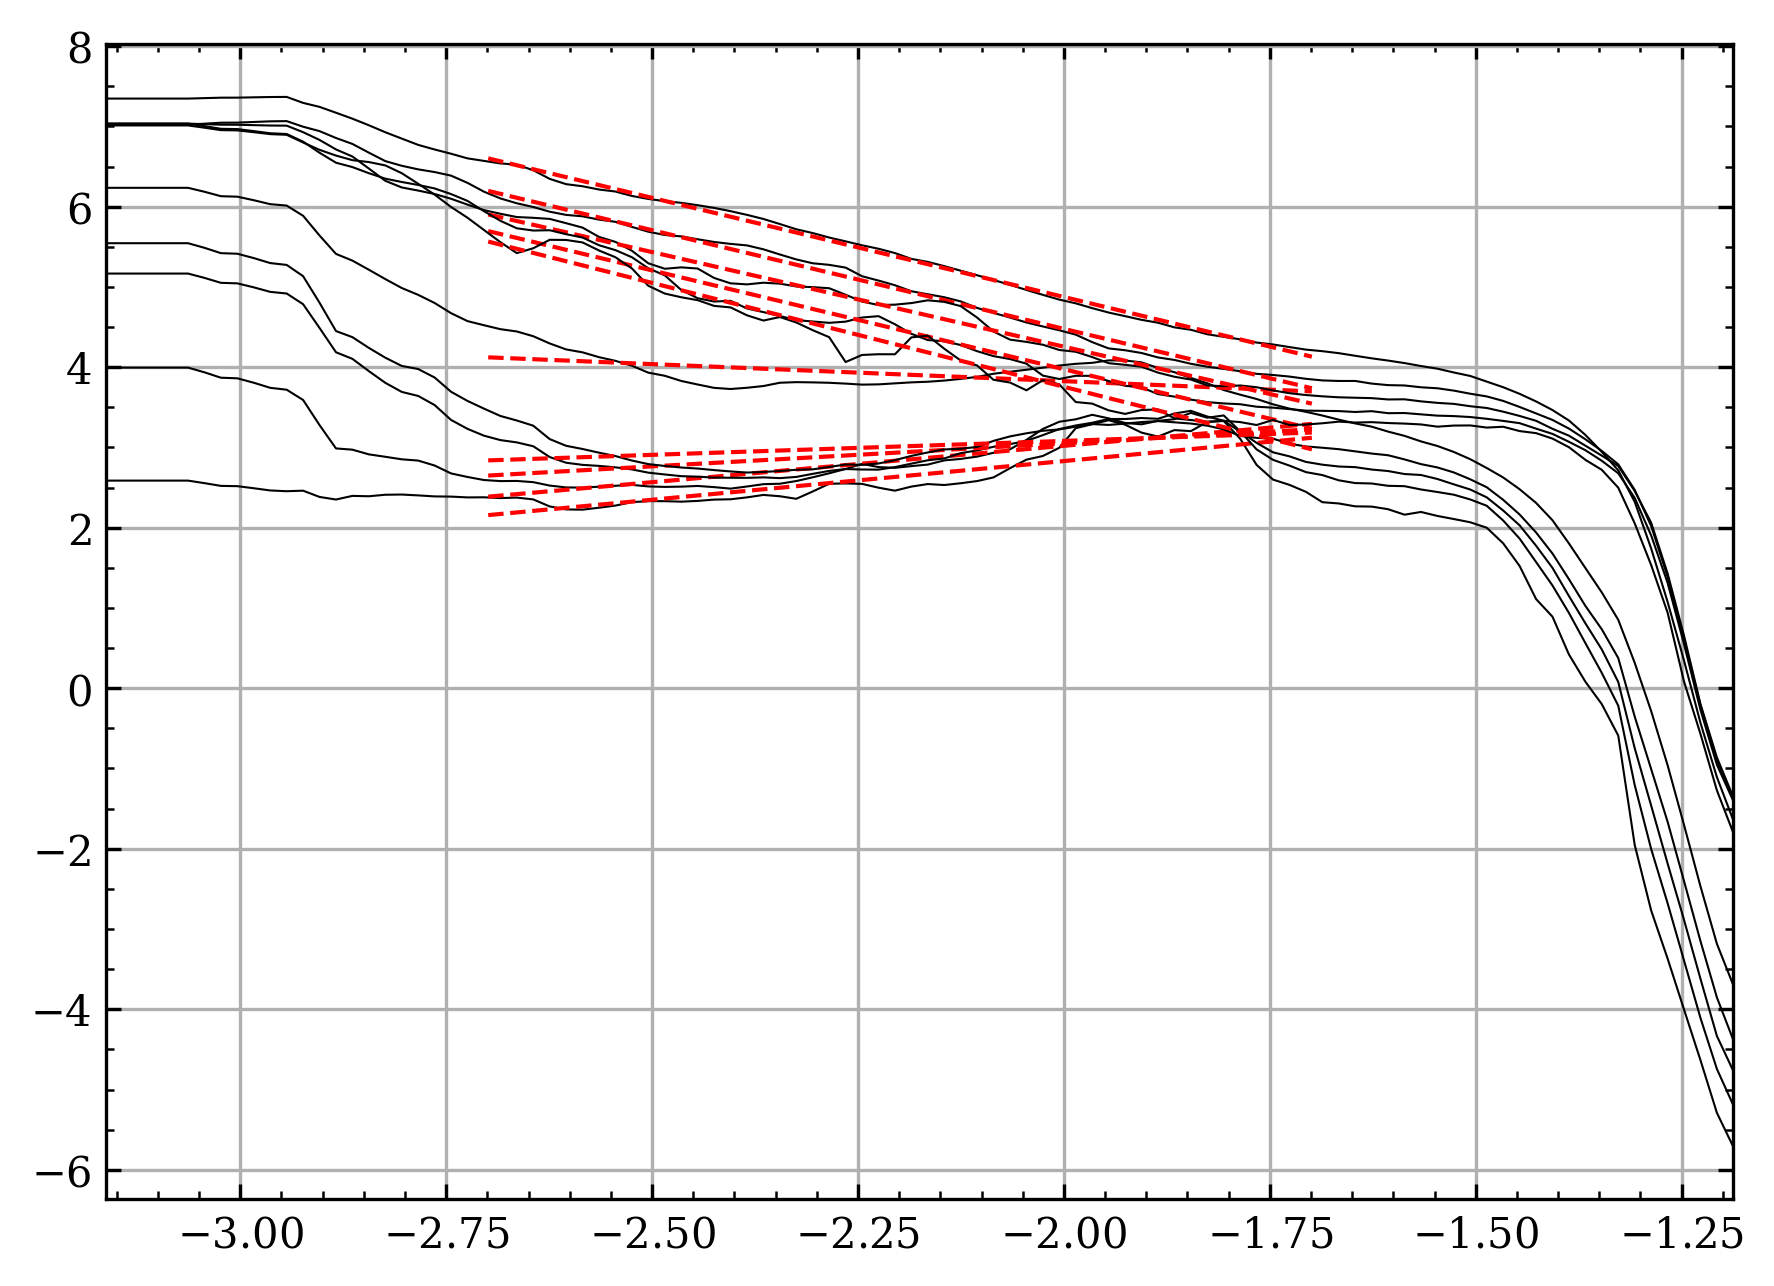

In [11]:
# Slopes
def powerlaw(x, amplitude, exponent, constant):
    return amplitude * x**exponent + constant


def line(x, m, c):
    return m * x + c


min_x = 2e-3
max_x = 2e-2


def fitline(arr, min_x, max_x, func):
    # arr.shape = (n_chunks, 2) where 2 is (x, y)
    mask = (arr[:, 0] >= min_x) & (arr[:, 0] <= max_x)
    arr = np.log10(arr[mask, :])
    fit, _ = optimize.curve_fit(func, arr[:, 0], arr[:, 1])
    return fit


fig, ax = plt.subplots()
slopes = np.empty((cs.n_chunks, 2))
for i, s in enumerate(segments):
    slopes[i, :] = fitline(s, min_x, max_x, line)
    ax.plot(*np.log10(s).T, c="k", ls="-", lw=0.5)
    xr = np.log10(np.linspace(min_x, max_x, 2))
    ax.plot(xr, line(xr, *slopes[i, :]), c="r", ls="--")

plt.show()


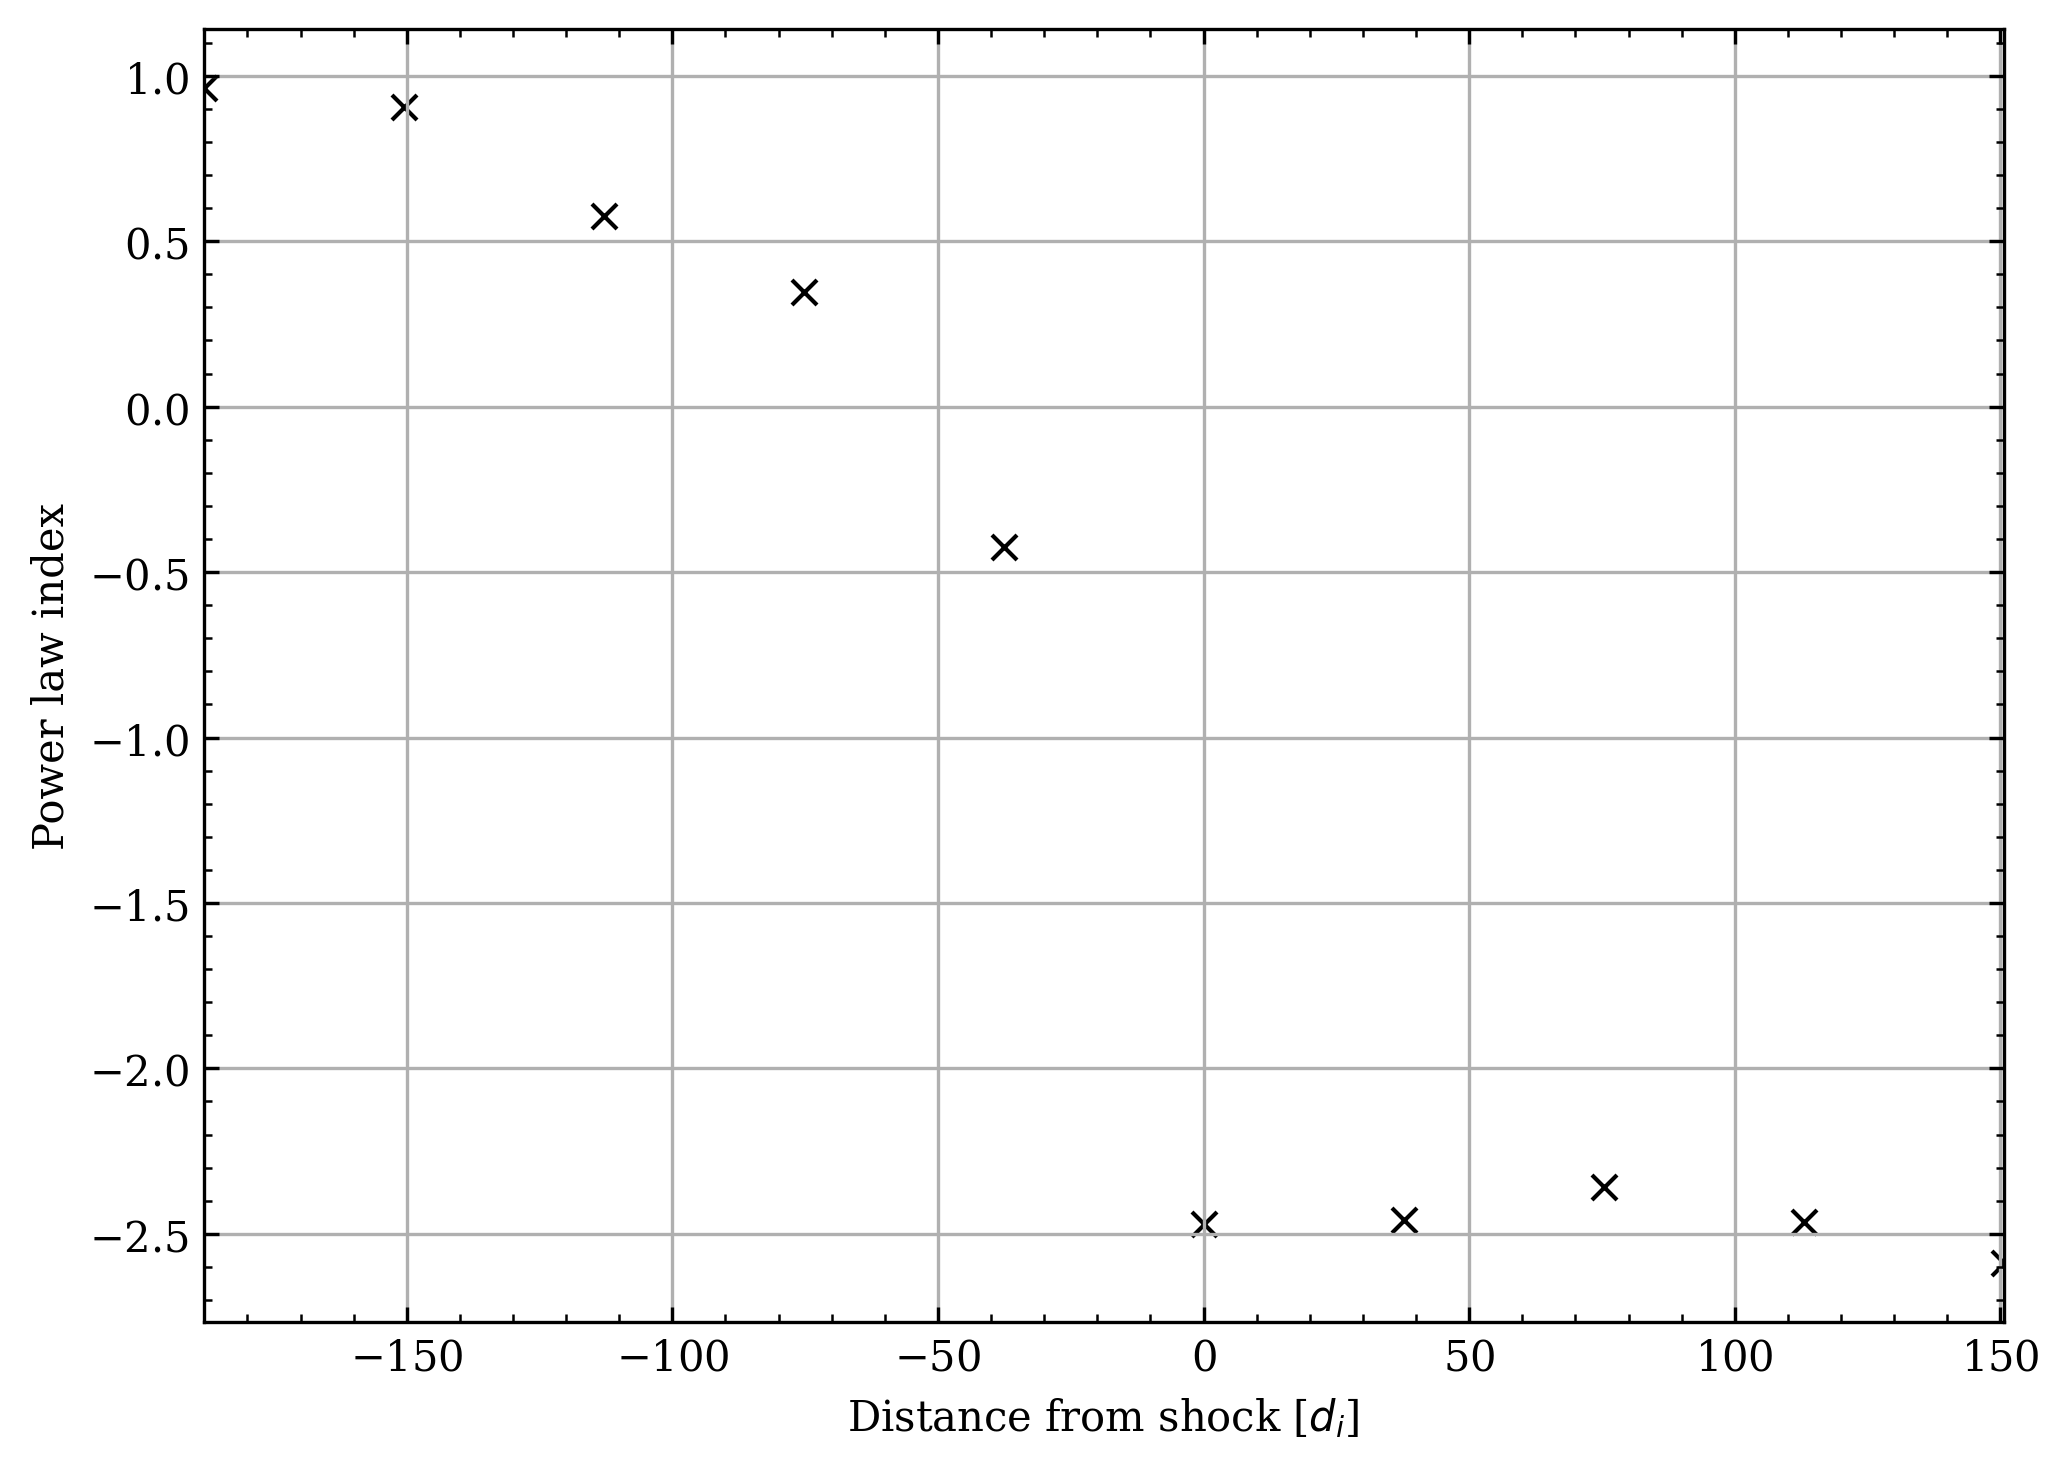

In [10]:
fig, ax = plt.subplots()

dists = (
    (np.arange(cs.n_chunks) - shock_chunk)
    * cs.dx
    * cs.chunk_i
    / (deck.constant.di * 1e-3)
)
ax.scatter(dists, slopes[:, 0], c="k", marker="x")  # type: ignore

ax.set_xlabel("Distance from shock [$d_i$]")
ax.set_ylabel("Power law index")


fig.tight_layout()
plt.show()
